## Land use and cover changes under deforastation

### Amazon and Cerrado Biomes

In [9]:
# Importing Packeges

import rasterio
from rasterio.features import shapes
from rasterio.mask import mask as mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import shapes
from rasterio.plot import show 
from shapely.geometry import shape
import numpy as np
import fiona
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from osgeo import gdal
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import seaborn as sns

print(f'Rasterio version: {rasterio.__version__}')
print(f'fiona version: {fiona.__version__}')

Rasterio version: 1.2.6
fiona version: 1.8.20


#### Reading paths and files

In [14]:
# Defining variables and paths:

YEAR = 2020
ROI = 'Agricultural-Expansion'

ROI_SHAPE = "data/desmatamento_bioma_amz_PRODES_2020.shp"
ROI_LUC = f"data/LUC_mapbiomas-brazil-collection-7-matogrosso-2020-projetado-SIRGAS2000.tif"

export_tif_path_luc = f"data/image_{YEAR}_LUC_{ROI}.tif"

In [71]:
# Defining clip function

def cropa_tif_from_shp(shp_path, tif_path, export_tif_path):
    print(f'- Cropando {tif_path} com {shp_path}')
    with fiona.open(shp_path, "r") as shapefile:
        roi_shapes = [feature["geometry"] for feature in shapefile]
    
    tif_open = rasterio.open(tif_path)
    masked_tif, masked_tif_transform = rasterio.mask.mask(tif_open, roi_shapes, crop=True) 
    scar_meta = tif_open.meta
    
    scar_meta.update({ 
                 "height": masked_tif.shape[1],
                 "width": masked_tif.shape[2],
                 "transform": masked_tif_transform,
                 "nodata": 0})
    
    tif_result = np.where(masked_tif==256, 0, masked_tif)

    
    print(f'Salvando em {export_tif_path}\n')
    with rasterio.open(export_tif_path, "w", **scar_meta) as dest:
        dest.write(tif_result)

In [72]:
# Defining poligonize function

def poligoniza(tiff_path, shp_path):
    cmd_command = f'gdal_polygonize.py {tiff_path} {shp_path}'
    print(f'- Poligonizando {tiff_path} -> {shp_path}')
    os.system(cmd_command)
    print('')

In [73]:
# Defining clip and poligonize function

def cropa_e_poligoniza(input_shp_path, input_tif_path, output_shp_path):
    crop_tif_path = output_shp_path.replace('.shp', '.tif')
    cropa_tif_from_shp(input_shp_path, input_tif_path, crop_tif_path)
    poligoniza(crop_tif_path, output_shp_path)

In [74]:
# Defining save file path

luc_deforastation_roi_shp_path = f'data/LUC_deforastation_{YEAR}_{ROI}.shp'

In [75]:
# Cliping and poligonizing function

cropa_e_poligoniza(ROI_SHAPE, ROI_LUC, luc_deforastation_roi_shp_path)

- Cropando data/LUC_mapbiomas-brazil-collection-7-matogrosso-2020-projetado-SIRGAS2000.tif com data/desmatamento_bioma_amz_PRODES_2020.shp
Salvando em data/LUC_deforastation_2020_Agricultural-Expansion.tif

- Poligonizando data/LUC_deforastation_2020_Agricultural-Expansion.tif -> data/LUC_deforastation_2020_Agricultural-Expansion.shp
0...10...20...30...40...50...60...70...80...90...100 - done.



In [16]:
# Clip function 

cropa_tif_from_shp(ROI_SHAPE, ROI_LUC, export_tif_path_luc)

- Cropando data/LUC_mapbiomas-brazil-collection-7-matogrosso-2020-projetado-SIRGAS2000.tif com data/desmatamento_bioma_amz_PRODES_2020.shp
Salvando em data/image_2020_LUC_Agricultural-Expansion.tif



In [17]:
# ROI LUC
luc_open = rasterio.open(export_tif_path_luc)

# Data type:
print(type(luc_open))

# LUC ROI variable
luc_roi = luc_open.read(1)
print(luc_roi)

<class 'rasterio.io.DatasetReader'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
# Raster resolution (degrees)

gt = luc_open.transform
pixelSizeX = gt[0]
pixelSizeY =-gt[4]
print (pixelSizeX, pixelSizeY)

0.0002694945852358563 0.0002694945852358563


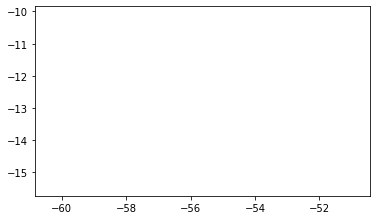

<AxesSubplot:>

In [19]:
# Visualizing LUC ROI:

show(luc_open, transform=luc_open.transform, cmap='viridis')

In [22]:
# Reading LUC ROI classes

luc_roi = luc_open.read(1)
np.unique(luc_roi)

array([ 0,  3,  4,  9, 11, 12, 15, 24, 30, 33, 39, 41], dtype=uint8)

In [25]:
# Counting pixels in each class
np.unique(luc_roi, return_counts=True)

(array([ 0,  3,  4,  9, 11, 12, 15, 24, 30, 33, 39, 41], dtype=uint8),
 array([842744687,     60583,      1758,        43,       159,       173,
           257633,        36,        31,       181,      1341,     15625]))

In [26]:
unique, counts = np.unique(luc_roi, return_counts=True)

In [81]:
# NaN to 0 values

luc_roi == 0
luc_roi[luc_roi==0]
luc_roi_float = luc_roi.astype('float')
luc_roi_float[luc_roi_float==0] = np.nan
luc_roi_float

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

<BarContainer object of 11 artists>

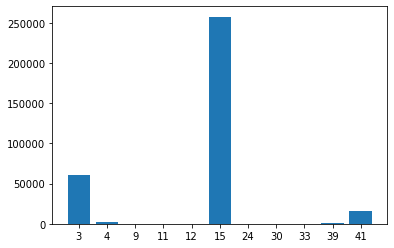

In [83]:
# Classes distribution

plt.bar(luc_unique.astype('str'), luc_counts)

In [44]:
# Calculating area function

def calcula_area_shp_ha(shp_path):
    gdf = gpd.read_file(luc_deforastation_roi_shp_path)
    gdf = gdf['geometry'].to_crs({'proj':'cea'}) 
    return sum(gdf.area)/10_000

In [53]:
# Total LUC Deforastation area

area_LUC_ha = calcula_area_shp_ha(luc_deforastation_roi_shp_path)
area_LUC_ha

30133.168957908194

In [33]:
# Creating legend

luc_legend =  {
    '0':'Não definido',
    '1': 'Floresta',
    '3':'Formação Florestal',
    '4':'Formação Savânica',
    '9':'Silvicultura',
    '11':'Campo Alagado e Área Pantanosa',
    '12':'Formação Campestre',
    '13':'Outras Formações Não Florestais',
    '15':'Pastagem', 
    '20':'Cana-de-açúcar',
    '21':'Mosaico de agricultura e Pastagem', 
    '24':'Área Urbanizada',
    '25':'Outras áreas não vegetadas',
    '29':'Afloramento Rochoso',
    '30':'Mineração', 
    '33':'Rio, Lago e Oceano', 
    '39':'Soja', 
    '41':'Outras Lavouras Temporárias', 
    '46':'Café',
    '48':'Outras Lavouras Perenes', 
    '62': 'Algodão'
}


In [89]:
# Iterando areas queimadas + luc com a legenda:

for id_luc in unique:
    print(id_luc, luc_legend[str(id_luc)])

0 Não definido
3 Formação Florestal
4 Formação Savânica
9 Silvicultura
11 Campo Alagado e Área Pantanosa
12 Formação Campestre
15 Pastagem
24 Área Urbanizada
30 Mineração
33 Rio, Lago e Oceano
39 Soja
41 Outras Lavouras Temporárias


In [85]:
# Construindo a legenda:

luc_labels = [] 
for classe_luc in unique:
    #print(classe_luc)
    luc_labels.append(luc_legend[str(classe_luc)])
    #print(luc_labels)

In [59]:
# Filtrando áreas de menor significância para aparecer no gráfico:

filter_area = []
filter_labels = []
limite_area_ha = 1

for i in range(len(area_luc)):
    if area_luc[i]>limite_area_ha:
        print(area_luc[i])
        filter_area.append(area_luc[i])
        filter_labels.append(luc_labels[i])

TypeError: 'float' object cannot be interpreted as an integer